In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob

In [10]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
num_exp = 1000

In [12]:
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 
    'B_x_Mean', 'B_x_Std', 'Noise', 'B_x_tilde_Mean', 'B_x_tilde_Std'
    ])

category = "MicroscopyImages"
pair = list(itertools.combinations(image_numbers, 2))[0]  # Choose the first image pair as an example

print(f'Category: {category}, Image_Pair: {pair}')

Category: MicroscopyImages, Image_Pair: ('01', '02')


In [13]:
for noise in noise_values:
    alpha_1s = np.zeros(num_exp)
    alpha_2s = np.zeros(num_exp)
    B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
    B_xs_tilde = np.zeros((num_exp, resolution, resolution))  # Store B_x_tilde for each experiment
    image1 = Image(resolution, category, pair[0], full_path)
    image2 = Image(resolution, category, pair[1], full_path)

    for i in range(num_exp):
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1
        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2
        B_xs[i, :, :] = B_x  # Store each B_x result
        B_xs_tilde[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

    # Calculate the means and standard deviations
    alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
    alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
    B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)
    B_x_tilde_mean, B_x_tilde_std = B_xs_tilde.mean(axis=0), B_xs_tilde.std(axis=0)

    # Store results in the DataFrame
    results_B_x = results_B_x._append({
        'Category': category,
        'Noise': noise,
        'Image_Pair': pair,
        'Alpha_1_Mean': alpha_1_mean,
        'Alpha_1_Std': alpha_1_std,
        'Alpha_2_Mean': alpha_2_mean,
        'Alpha_2_Std': alpha_2_std,
        'B_x_Mean': B_x_mean.mean(),  # Storing the overall mean of the matrix
        'B_x_Std': B_x_std.mean(),  # Storing the overall mean of the std of the matrix
        'B_x_tilde_Mean': B_x_tilde_mean.mean(),
        'B_x_tilde_Std': B_x_tilde_std.mean()
    }, ignore_index=True)

C:\Users\eriki\AppData\Local\Temp\ipykernel_22892\2892555043.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


In [8]:
results_B_x_new = results_B_x.drop(['Category', 'Image_Pair'], axis=1)
results_B_x_new['log_Noise'] = np.log10(results_B_x['Noise'])
grouped_results = results_B_x_new.groupby('Noise').mean().reset_index()
results_B_x_new.head()

,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise,B_x_tilde_Mean,B_x_tilde_Std,log_Noise
0,-0.000002,2.603531e-07,-0.000002,3.014808e-07,-6.458317e-11,4.727199e-10,1.000000e-08,-2.860524e-16,3.372282e-14,-8.00000
1,-0.000003,3.807417e-07,-0.000003,3.786777e-07,3.806875e-11,6.092159e-10,1.261857e-08,2.287442e-16,5.398055e-14,-7.89899
2,-0.000004,4.311007e-07,-0.000004,4.354700e-07,5.065852e-11,6.899810e-10,1.592283e-08,3.889873e-16,8.568936e-14,-7.79798
3,-0.000005,5.364897e-07,-0.000005,6.417035e-07,-4.346153e-12,9.673625e-10,2.009233e-08,7.948193e-17,1.364141e-13,-7.69697
4,-0.000006,7.062610e-07,-0.000006,8.128188e-07,-1.056315e-10,1.236597e-09,2.535364e-08,-1.115442e-15,2.164055e-13,-7.59596


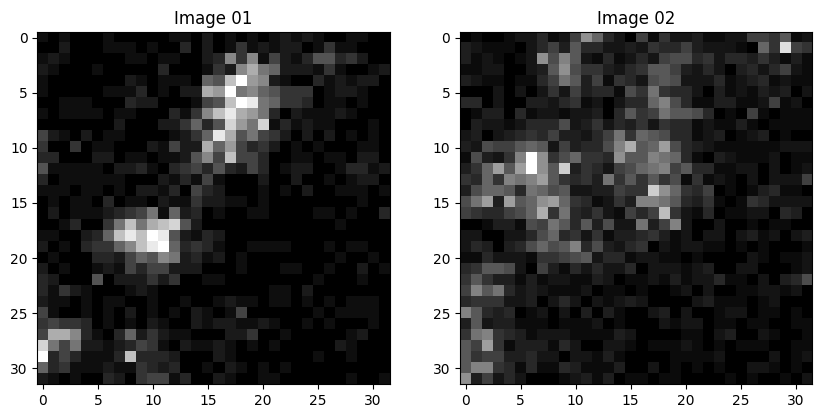

In [16]:
# Show both original images side by side:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1.image, cmap='gray')
ax[0].set_title(f'Image {pair[0]}')
ax[1].imshow(image2.image, cmap='gray')
ax[1].set_title(f'Image {pair[1]}')
plt.show()

In [40]:
def print_stats(image: np.ndarray):
    print(f'Min: {image[image>0].min()}')
    print(f'Max: {image[image>0].max()}')
    print(f'Mean: {image.mean()}')
    print(f'Num of zeros: {np.count_nonzero(image == 0)}')

In [41]:
type(image1)

utils.image.Image

In [42]:
# Show statistics about the images - mean pixel value, number of zero pixels, etc.
print(f'Image {pair[0]} statistics:')
print_stats(image1.image)
print(f'\nImage {pair[1]} statistics:')
print_stats(image2.image)

Image 01 statistics:
Min: 0.0005389797882579403
Max: 0.009817131857555342
Mean: 0.0009765625
Num of zeros: 429

Image 02 statistics:
Min: 0.00031292671825216206
Max: 0.007254210286754666
Mean: 0.0009765625
Num of zeros: 173


Now, we would like to see that the noise value is capped at about the same time as the minimal value is equal to 

$$min_{pix} = \sigma \sqrt{2log(N^2)}$$

which in our case, where $N=32$, means that:

$$min_{pix} = \sigma \sqrt{2log(1024)}$$

and if we move things around a little we get : 

$$\sigma < \frac{min_{pix}}{\sqrt{2log(1024)}}$$

In [47]:
# Calculate the minimal non-zero pixel value in the images
min_pix_image1 = image1.image[image1.image > 0].min()
min_pix_image2 = image2.image[image2.image > 0].min()

max_sigma_image1 = min_pix_image1 / np.sqrt(2 * (resolution**2))
max_sigma_image2 = min_pix_image2 / np.sqrt(2 * (resolution**2))

print(f'Minimal non-zero pixel value in image {pair[0]}: {min_pix_image1}')
print(f'Maximal sigma value for image {pair[0]}: {max_sigma_image1}')
print(f'\nMinimal non-zero pixel value in image {pair[1]}: {min_pix_image2}')
print(f'Maximal sigma value for image {pair[1]}: {max_sigma_image2}')

Minimal non-zero pixel value in image 01: 0.0005389797882579403
Maximal sigma value for image 01: 1.1909883224989972e-05

Minimal non-zero pixel value in image 02: 0.00031292671825216206
Maximal sigma value for image 02: 6.9147688903298735e-06


In [49]:
max_sigma_image1

1.1909883224989972e-05

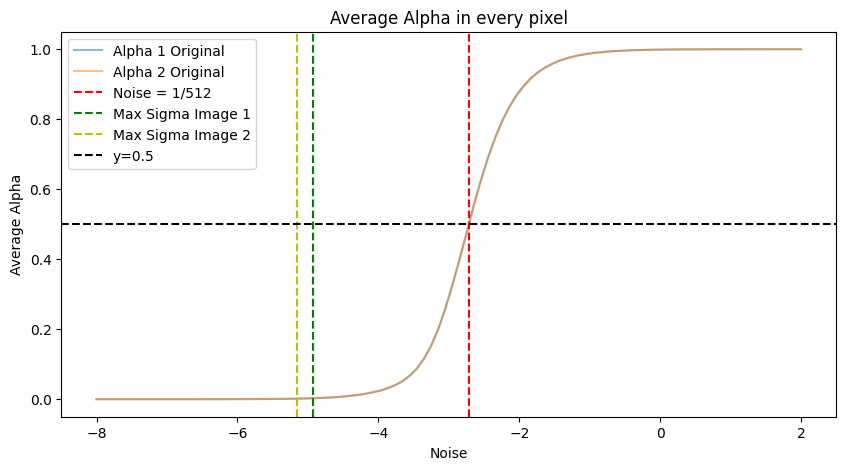

In [54]:
# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_1_Mean'], label='Alpha 1 Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_2_Mean'], label='Alpha 2 Original', alpha=0.5)
plt.axvline(x=np.log10(1/512), color='r', linestyle='--', label='Noise = 1/512')
plt.axvline(x=np.log10(max_sigma_image1), color='g', linestyle='--', label='Max Sigma Image 1')
plt.axvline(x=np.log10(max_sigma_image2), color='y', linestyle='--', label='Max Sigma Image 2')
plt.axhline(y=0.5, color='k', linestyle='--', label='y=0.5')
plt.xlabel('Noise')
#plt.yscale('log')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

plt.show()

Questions about this plot:
* is it symmetric around the point $(0.5, \frac{2}{res^2})$

* What are the max sigma's and how can we interpret them? do the things we want really start happening there?

* How would one change the theoretical proof given that we can divide the pixels into 2 parts.

I would be adressing the third point in the overleaf page.